In [1]:
'''Import standard packages'''
import numpy as np
import matplotlib.pyplot as plt


## PHYS 481 Assignment 5

November 22, 2018

Kenneth Sharman (00300185)

### Introduction

There are numerous numerical techniques for solving differential equations. So far in computational physics we have not covered the method of using discrete difference equations to arrive at a solution to a particular problem. This week we will investigate modelling the one-dimensional wave equation using a difference equation. These models are relatively simply to implement and go hand in hand with data collection. However, the discretization of the domain must be properly implemented in order to keep the associated errors in check. This report will focus on the implementation of such a model and investigate the effect that the parameters have on the error. We will start with the differential equation of a standing wave and build up the model, piece by piece.

A one-dimensional wave can be modelled by the differential equation
$$ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} $$
Suppose that we have the initial conditions,
$$ u(x,0) = A \sin \Big( \frac{\pi}{L}mx \Big) \qquad x \in [0,L]$$
$$ \frac{\partial}{\partial t} u(x,0) = 0 \qquad x \in [0,L] $$

and that the wave is fixed at the endpoints

$$ u(0,t) = 0 \qquad \text{and} \qquad u(L,t) = 0 \qquad t \in (0,T] $$
The solution to this differential equation is
$$ u_e(x,t) = A \sin \Big(  \frac{\pi}{L}mx \Big) \cos \Big(  \frac{\pi}{L}mct \Big) $$

### Explain wavelength and period for $\sin(kx)\cos(\omega t)$

For a sine wave of the form $\sin(kx)$ we usually think of $k=\frac{2\pi}{T}$ where $T$ is the period. However, in this case the wave is a function of distance. This means that instead of a period we refer to the wavelength $\lambda$, hence $$k=\frac{2\pi}{\lambda} \qquad \Longrightarrow \qquad \lambda = \frac{2\pi}{k}$$
The wavelength is the spatial period of a periodic wave and represents the distance over which the wave's shape repeats [1].

For a cosine wave of the form $\cos(\omega t)$ we do have a temporal period, which we will denote as $P$.

$$ \omega = \frac{2\pi}{P} \qquad \Longrightarrow \qquad P = \frac{2\pi}{\omega} $$

As mentioned, the analytic solution to the one-dimensional wave equation is

$$ u_e(x,t) = A\sin\Big( \frac{\pi}{L}mx \Big) \cos\Big( \frac{\pi}{L}mct \Big) $$

Using the above work to determine the wavelength
$$ k = \frac{\pi m}{L} \qquad \Longrightarrow \qquad \lambda = \frac{2L}{m} $$
and the period
$$ \omega = \frac{\pi m c}{L} \qquad \Longrightarrow \qquad P = \frac{2L}{mc} $$

Knowing these values with help us with the analysis in this report. Before we proceed, a plot is constructed to visualize the period and wavelength.

Note: In an applied example, each of the parameters would have a specific set of units. Here we will assume SI units.

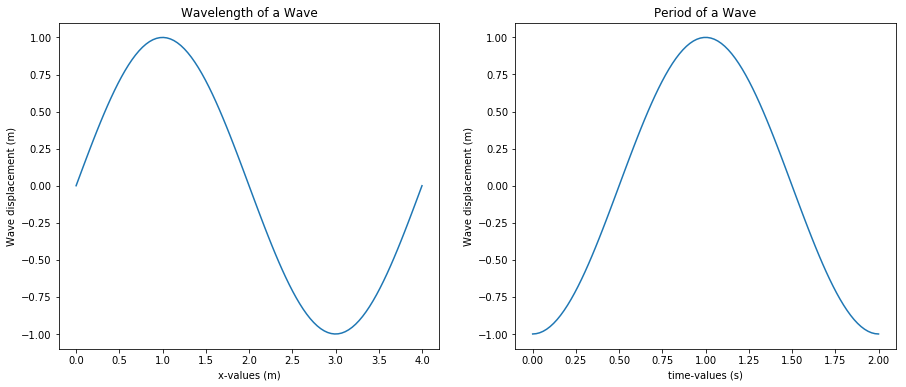

In [2]:
'''Plot wavelength and period of analytic solution to 1D wave equation'''
A, L, m, c = 1.0, 2.0, 1.0, 2.0 # set arbitrary values for wave solution

def calc_analytic_soln(x, t):
    '''
    Function returns analytic solution to the 1D wave equation.
    Parameters
        x: spatial value(s)
        t: temporal value(s)
    '''
    return A*np.sin((np.pi/L)*m*x) * np.cos((np.pi/L)*m*c*t)

plt.figure(figsize=(15, 6)); # Set plot size

x_vals = np.linspace(0, 4, 100) # spatial values to show wavelength
t_vals = np.linspace(0, 2, 100) # temporal values to show period

plt.subplot(1, 2, 1); plt.title('Wavelength of a Wave')
plt.plot(x_vals, calc_analytic_soln(x_vals, t=0)) # plot 1 full wavelength
plt.xlabel('x-values (m)',); plt.ylabel('Wave displacement (m)')

plt.subplot(1, 2, 2); plt.title('Period of a Wave')
plt.plot(t_vals, calc_analytic_soln(x=3.0, t=t_vals)) # plot 1 full period
plt.xlabel('time-values (s)',); plt.ylabel('Wave displacement (m)')

plt.show()


Now that we have a better idea of the parameters associated with the equation of a wave, we can begin constructing the discrete difference equation model to the solution of the wave equation. 

#### Discretizing the Domain
Both the temporal domain $[0,T]$ and the spatial domain $[0,L]$ can represented by a finite number of mesh points, and implemented using numpy arrays. As we will see, the spacing of these grids is essential, but there is some work required to get to a level of understanding of how exactly they should be constructed.

The second-order derivatives in the wave equation can be replaced by the following difference equations [2]

$$ \frac{\partial^2}{dt^2} u(x_i,t_n) \approx \frac{{u_i}^{n+1} - 2 {u_i}^n + {u_i}^{n-1} }{\Delta t^2} $$
$$ \frac{\partial^2}{\partial x^2}u(x_i,t_n) \approx \frac{{u_{i+1}}^n -2 {u_i}^n + {u_{i-1}}^n }{\Delta x^2} $$

The wave equation can therefore be written as a finite difference equation with the form

$$ \frac{{u_i}^{n+1} - 2 {u_i}^n + {u_i}^{n-1} }{\Delta t^2} = c^2 \frac{{u_{i+1}}^n -2 {u_i}^n + {u_{i-1}}^n }{\Delta x^2} $$

Note that this equation will only be satisfied in the interior points of the two-dimensional domain since the nearest neighbors of the previous generation are required.
Expressing the second initial condition in terms of a finite difference equation gives

$$ \frac{\partial}{\partial t} u(x_i,0) \approx \frac{{u_i}^{1} - {u_i}^{-1}}{2 \Delta t} $$
and the other initial condition imposes the condition
$$ {u_i}^0 = A\sin\Big( \frac{\pi}{L} m x_i \Big) \qquad i=0,\dots,N_x $$

#### Formulating the recursive algorithm
Assume that ${u_i}^n$ and ${u_i}^{n-1}$ are known for $i=0,\dots,N_x$. We must solve for ${u_i}^{n+1}$ by rearranging the finite difference equation

$$ {u_i}^{n+1} = -{u_i}^{n-1} + 2{u_i}^{n} + C^2 ({u_{i+1}}^{n} -2{u_i}^{n} + {u_{i-1}}^{n} ) \qquad [1]$$

where the parameter $C$ is known as the $\textit{Courant number}$

$$ C = c \frac{\Delta t}{\Delta x} $$

If we wish to begin this recursive algorithm at ${u_i}^{2}$ the above equation tells us that we need both ${u_i}^{0}$ and ${u_i}^{1}$. The initial conditions give the former and the latter can be determined by combining the initial conditions with equation 1.

$$ {u_i}^{1} = {u_i}^{0} + \frac{1}{2} C^2 ({u_{i+1}}^{0} -2{u_i}^{0} + {u_{i-1}}^{0} ) \qquad [2] $$

The above theory will be implemented to find a solution to the wave equation. The assignment question asked for various functions to be imported from a textbook [2], such that the numeric and analytic solution and/ or the error could be plotted. Instead of using code written by someone else, I decided to write my own (albeit strongly based off the recommended source!). Instead of using loops to populate the wave values at the next time value, matrix methods were utilized. The entirety of the code was wrapped into a class for clean presentation.

In [3]:
'''Define class with all appropriate functions/attributes'''
class OneDWave:
    '''
    Class represents the solution to the 1d wave equation, with the initial
    conditions specified above.
    '''
    def __init__(self, L, T, A, m, c):
        '''
        Constructor initializes all parameters and calls __init__generations method
        Parameters
            L: length of spatial domain
            T: length of temporal domain
            A: amplitude of wave
            m: solution to wave equation has m-1 nodes in 1 wavelength
            c: speed propagation
        '''
        self.L, self.T = L, T # Initialize domain lengths
        self.x, self.t = np.linspace(0, L, 100), np.linspace(0, T, 100) # domain arrays
        self.Nx, self.Nt = len(self.x)-1, len(self.t)-1 # number of elements in domains
        self.dx, self.dt = self.x[1]-self.x[0], self.t[1]-self.t[0] # spacing of domains
        self.A, self.m, self.c, self.C2 = A, m, c, (c*self.dt/self.dx)**2 # wave parameters
        self.__init__generations()

    def initial_cond(self, x):
        '''
        Function calculates and returns initial conditions using specified equation
        Parameter x: spatial domain values
        '''
        return self.A * np.sin((np.pi/self.L)*self.m*x)

    def calc_analytic_soln(self, time=0):
        '''
        Function calculates value(s) of analytical solution and assigns value to instance
        variable self.analytic. Function used in different context than initial_cond function
        Parameter time: time value for which solution is desired
        '''
        self.analytic = self.A*np.sin((np.pi/self.L)*self.m*self.x) \
            *np.cos((np.pi/self.L)*self.m*self.c*time) # equation of analytic solution

    def __init__generations(self):
        '''
        Constructor initializes three arrays for wave values; u_nm1, u_n, u corresponding
        to; t_0, t_1, and t_2 respectively.
        '''
        self.u, self.u_n = np.zeros(len(self.x)), np.zeros(len(self.x))
        self.u_nm1 = np.zeros(len(self.x)) # Initialize empty arrays
        self.u_n = self.initial_cond(self.x[:]) # Use initial conditions
        # Use equation [2] to calculate wave at first time after t_0
        self.u[1:-1] = self.u_n[1:-1] + 0.5*self.C2*(self.u_n[2:]-2*self.u_n[1:-1]+self.u_n[:-2])
        self.u_nm1[:], self.u_n[:] = self.u_n, self.u # swap arrays so that u_nm1 is at t_0
        self.calc_analytic_soln(time=0) # calculate analytic solution at t_0

    def update_u(self):
        '''
        Function calculates new generation of wave values using equation [1]
        '''
        # Update all inner mesh points at time t[n+1]
        self.u[1:-1] = -self.u_nm1[1:-1] + 2*self.u_n[1:-1] \
        + self.C2*(self.u_n[2:]-2*self.u_n[1:-1]+self.u_n[:-2])
        self.u_nm1[:], self.u_n[:] = self.u_n, self.u # swap arrays to step forward in time

    def step(self, plot=False):
        '''
        Function steps through all of the times in the spatial domain. Analytic solution is
        updated to final time value.
        Parameter plot: If true, creates a superimposed plot with the wave value, for every
        fifth time step. Default value is False.
        '''
        if plot:
            plt.figure(figsize=(15, 10))
            plt.title('Propagation of the Wave from $T_0$ to $T=2.25$', fontsize='xx-large')
            plt.xlabel('x-values (m)', fontsize='x-large')
            plt.ylabel('Wave Displacement (m)', fontsize='x-large')
            plt.plot(self.x, self.u_nm1, label='Initial')
            for n in range(1, self.Nt): # update wave over every time in spatial domain
                self.update_u()
                if n%5 == 0 or n == self.Nt-1: # and for every fifth step & last, plot wave
                    plt.plot(self.x, self.u, label='n='+str(n))
            plt.legend(title='Steps'); plt.grid()
        else: # if plot==Flase; simply update wave over time domain
            for n in range(1, self.Nt):
                self.update_u()

        self.calc_analytic_soln(time=self.T) # update analytic solution


Before we implement this class, it is a good idea to run a test. We expect that by using the initial conditions, the wave at $t_0 = 0$ will be equal to the analytical solution at $t=0$. Let's run at test with relatively low tolerance to verify this is the case. 

In [4]:
'''Run a test to verify class was instantiated properly'''
def test_class1DWave():
    '''
    Test class asserts that u_nm1(t=0) is within 1e-16 of the analytic solution
    '''
    test_wave = OneDWave(L=50,T=100,A=1e-6,m=16,c=2) # Assign random numbers
    assert np.abs(max(test_wave.u_nm1-test_wave.analytic)) < 1e-16, 'Wave not initialize properly'
    
test_class1DWave()

It looks as though the class is initializing the wave properly. Let's also verify that, given a set of parameters, the period and wavelength are correct.

Let:

$L = 18m \qquad m=2 \qquad c = 1 \frac{m}{s}$

Using the results from are analysis on the wave parameters

$$P = \frac{2L}{mc} = \frac{2(18m)}{2(2 \frac{m}{s})} = 9s$$

$$ \lambda = \frac{2L}{m} = \frac{2(18m)}{3} = 18m$$

To avoid a crowded plot, we will display these waves over a quarter period, $9s/4=2.25s$. We expect the wave to propagate to a point where it is flat, and observe a wavelength of $18m$.

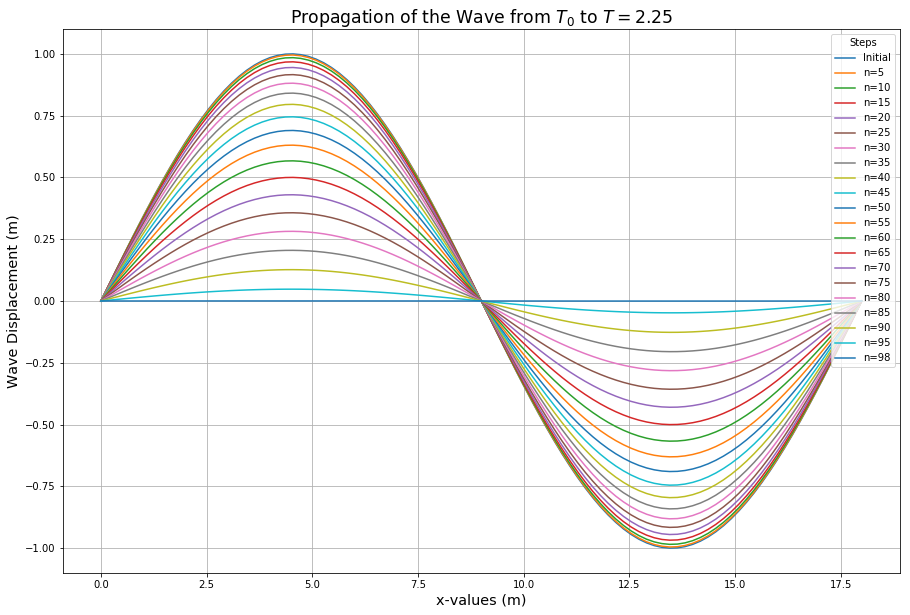

In [5]:
'''Plot wave over the course of 1/4 period to verify parameters'''
wave = OneDWave(L=18,T=2.25,A=1,m=2,c=2)
wave.step(plot=True)


Indeed, the period and wavelength appear to have been set-up properly. This plot isn't the most descriptive if you don't know what you are looking at. Perhaps a sequence of plots over a full period would better display the propagation of the wave.

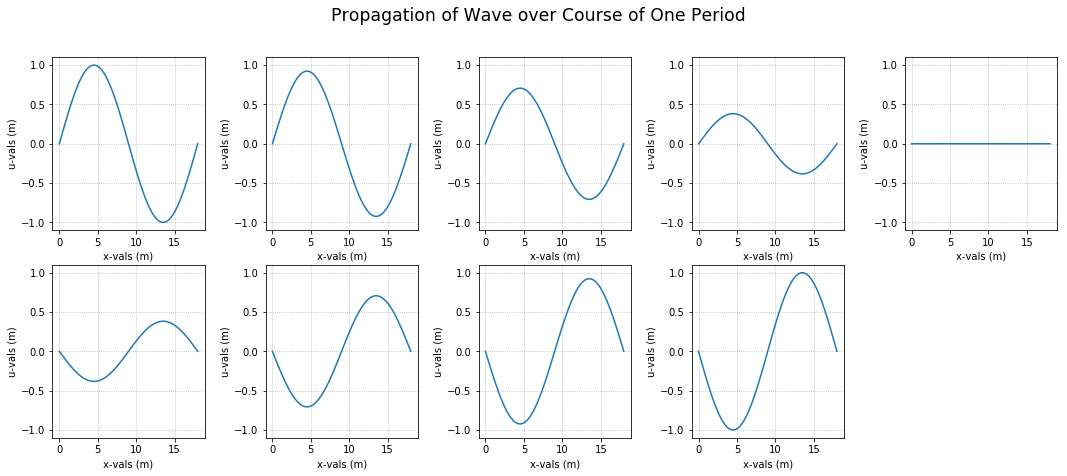

In [6]:
'''Plot the sequence of a wave over a period'''
plt.figure(figsize=(18, 7)) # Set the plot size
plt.suptitle('Propagation of Wave over Course of One Period', fontsize='xx-large')

for i in range(9): # Plot the wave over 1/8 of period increments
    ax = plt.subplot(2, 5, i+1)
    ax.set_ylim(-1.1, 1.1)
    wave = OneDWave(L=18, T=(i*1.125), A=1, m=2, c=1) # Instantiate wave
    wave.step() # step forward by 1/8 of a period
    plt.plot(wave.x, wave.u) # plot wave
    plt.xlabel('x-vals (m)'); plt.ylabel('u-vals (m)')
    plt.grid(linestyle=':')
plt.subplots_adjust(wspace=0.4)


These graphs give a better visual representation of how the wave varies over time. At this point the wave is set-up properly and appears to be properly advancing in time.

For a sanity check, let's plot the numeric and analytic solutions superimposed, to verify rough agreement in their values.

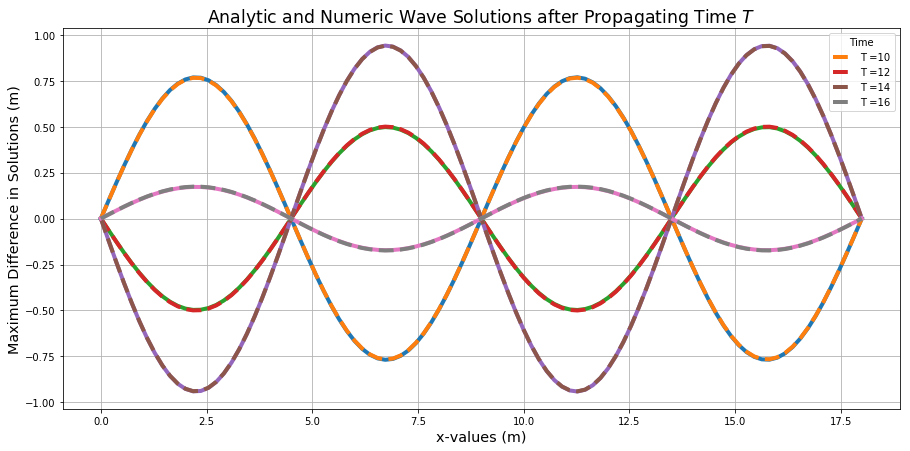

In [7]:
'''Plot the maximum error in numeric and analytic solutions over time'''
T_vals = np.arange(10, 18, 2)
plt.figure(figsize=(15, 7)); plt.grid()

for t in T_vals: # plot both solutions for few time values
    wave = OneDWave(L=18, T=t, A=1, m=4, c=1)
    wave.step()
    plt.plot(wave.x, wave.u, lw=4)
    plt.plot(wave.x, wave.analytic, lw=4, ls='--', label='T ='+str(t))

plt.title('Analytic and Numeric Wave Solutions after Propagating Time $T$', fontsize='xx-large')
plt.xlabel('x-values (m)', fontsize='x-large')
plt.ylabel('Maximum Difference in Solutions (m)', fontsize='x-large')
plt.legend(title='Time')
plt.show()


There looks to be fairly good agreement in the solutions for these time values. To get a more general idea and quantify the error, we need to dig a little deeper.

It is expected that for longer times the difference equation will deviate more and more from the analytic solution. To get a quantitative description of this, the maximum difference between the solutions can be plotted over a range of time values.


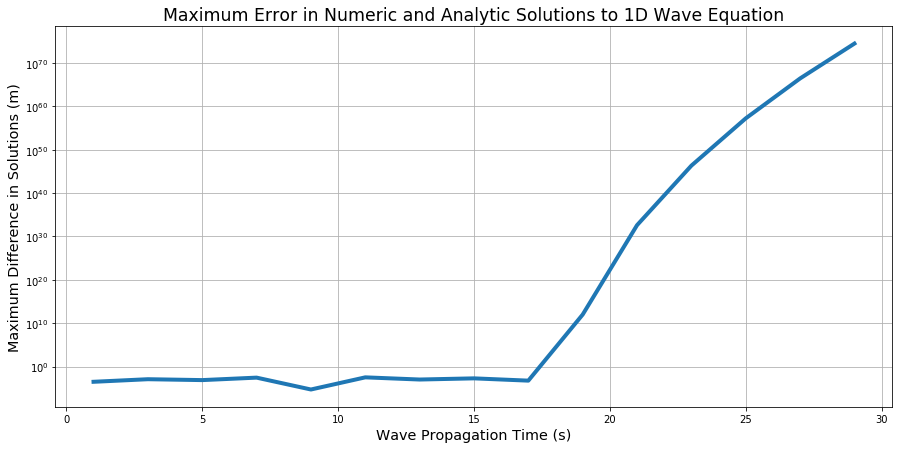

In [8]:
'''Plot the maximum error in numeric and analytic solutions over time'''
T_vals = np.arange(1,30,2) 
error_list = [] # maximum error in numerical and analytic solutions

for t in T_vals:
    wave = OneDWave(L=18,T=t,A=1,m=4,c=1)
    wave.step()
    error_list.append(max(np.abs(wave.u-wave.analytic)))

plt.figure(figsize=(15, 7)); plt.grid()
plt.semilogy(T_vals, error_list, lw=4)
plt.title('Maximum Error in Numeric and Analytic Solutions to 1D Wave Equation', fontsize='xx-large')
plt.xlabel('Wave Propagation Time (s)', fontsize='x-large')
plt.ylabel('Maximum Difference in Solutions (m)', fontsize='x-large')
plt.show()


As we can see from the plot, after roughly 18 seconds the error explodes. This behavior was a cause of great concern when it was first encountered and shed a fair amount of doubt that the OneDWave class was properly implemented. After a good deal of research, it was found that the time of 18 seconds actually corresponds to a critical value of this system. This value can be determined by investigating the Courant number.

As mentioned in the introduction, the Courant number is defined as

$$ C = c \frac{\Delta t}{\Delta x} $$

After doing some reading in the class recommended textbook [2] it was found that the Courant Number is responsible for the stability of the system. For $C\gt 1$ the system will diverge from the analytic solution. This makes sense if we look at equation [1]. When a new generation of the wave is calculated, the difference equation requires that the term $C^2$ is added to the wave value. Thus, for squared values larger than one we see that this term can become quite large and dominate the solution.

For the wave instantiated in the error analysis plot, we had the following parameters when the error exploded:

$$ L=18m \qquad T=19s \qquad A=1m \qquad m=4 \qquad c=1 \frac{m}{s} $$

In the OneDWave class, both the x and t domains have 100 elements. Thus,

$$ \Delta x = 0.18m \qquad \Delta t = 0.19s $$
and
$$ C = 1 \frac{m}{s} \frac{0.19s}{0.18m} = 1.06 \gt 1 $$

Now we see why the error suddenly exploded; that was the first-time value for which the Courant number was greater than one and therefore the solution became unstable. As it turns out; the Courant number is able to encapsulate the speed at which the wave is travelling w.r.t the grid. For faster speeds, the difference equation isn't able to contain the required amount of information, and the solution diverges from the analytic value. 

As a researcher this is a very import issue. For various reason it is ideal to make measurements spaced as far apart as the experiment permits (while still getting the required data), however if the analysis involves methods of discrete difference equations, then attention must be paid to the Courant number. Models using discrete difference equations can be somewhat tricky to balance properly, as the length and number of points in both the spatial and temporal domains, as well as the values of parameters (here the speed $c$) all influence the value of the Courant number. Changing one value may lead to unexpected changes in another.

While this solves the mystery of the unexpected jump in error, it would be useful to analyze the error associated with solutions that don't diverge. Let's plot the error associated with a range of Courant numbers.

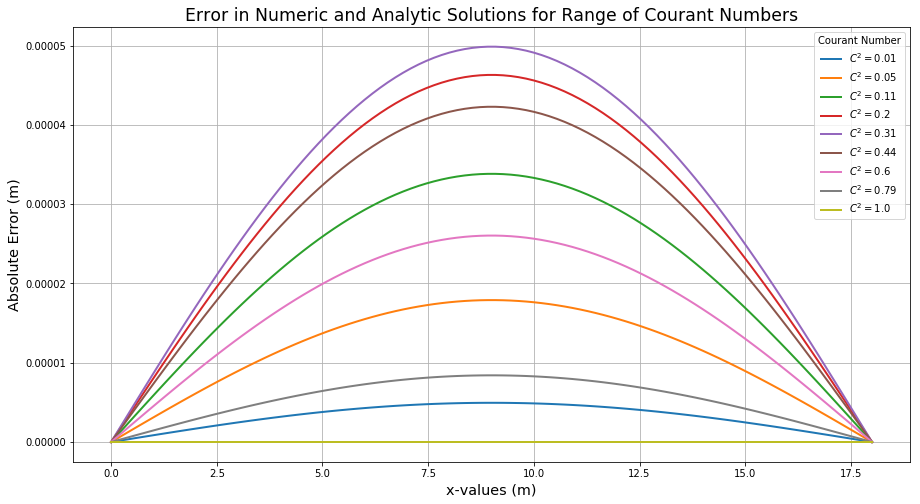

In [9]:
'''Plot Error Corresponding to Various Courant Numbers'''
plt.figure(figsize=(15, 8)); plt.grid()
time_list = np.arange(2, 19, 2)
error_list, courant_list = [], []

for time in time_list: # Change the Courant Number by changing the spacing in time domain
    wave = OneDWave(L=18, T=time, A=1, m=1, c=1)
    wave.step()
    error = np.abs(wave.u_n - wave.analytic)
    plt.plot(wave.x, error, lw=2, label='$C^2=$'+str(np.round(wave.C2, 2)))

plt.title('Error in Numeric and Analytic Solutions for Range of Courant Numbers', fontsize='xx-large')
plt.xlabel('x-values (m)', fontsize='x-large')
plt.ylabel('Absolute Error (m)', fontsize='x-large')
plt.legend(title='Courant Number')
plt.show()


This graph is actually very similar to the previous, with the difference being that the time range is limited to non-diverging solutions. By looking at the color coding in the legend we can see that the error is maximum for approximately $C^2 = 0.3$ and minimum for $C^2=1$.

Since we have only analyzed this one difference equation, it is not guaranteed or even likely that the minimum always occurs at $C=1$. Further, using this difference equation for analyzing data requires a delicate balance. Clearly, lower error is valued however it comes at the cost of being dangerously close to the region of instability.

### Conclusion

Using the discrete difference equation to model the solution to the second order differential wave equation proved relatively straightforward to implement. It appears the real challenge of using this method is how to properly select the parameters involved such that the error is minimized and at the same time, a safe distance is kept from the region where the solution diverges. 

This is no easy task for a practical, researched based setting. First of all, the behavior of the model, when implemented in code must be fully known. It is easy to imagine that other difference equations lead to much different behavior in terms of both divergence and minimizing the error. Once the behavior is known, and the parameters are appropriately selected, the challenge would then become to maintain a proper data acquisition procedure. If measurements are recorded later than expected, then extra work such as an intrapolation method may have to be used to get the model back on track.

About a month ago, I had no idea that discrete versions of differential equations even existed, nevermind that they were powerful enough to easily implement a solution to the one-dimensional wave equation. Very cool.


### References

[1] - https://en.wikipedia.org/wiki/Wavelength

[2] - Hans Petter Langtangen. $\textit{Finite Difference Computing with PDEs - A Modern Software Approach}$